# Práctica 2: Detección basada en ligandos: similitud de compuestos y agrupamiento de compuestos

> **Note:** Este libro esta disponible de dos maneras: 
> 1. Descargando el repositorio y siguiendo las instrucciones que estan en el archivo [README.md](https://github.com/ramirezlab/PILE/blob/main/README.md)
> 2. Haciendo clic aquí en [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramirezlab/PILE/blob/main/2.%20De%20datos%20a%20gráficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20química%20con%20python/2.4_Practica-2.es.ipynb?hl=es)

## Teoría

### **Huellas dactilares moleculares**
Las huellas dactilares moleculares son herramientas quimioinformáticas esenciales para el cribado virtual y el mapeo del espacio químico. Esta es una forma de describir una estructura molecular que puede convertir una estructura molecular en una cadena de bits<sup> **1** </sup>. Cada bit corresponde a una característica o entorno molecular predefinido, donde "1" representa la presencia y "0" la ausencia de una característica. Dado que la huella digital molecular codifica la estructura de una molécula, es un método útil para describir la similitud estructural entre las moléculas como un descriptor molecular.

#### **Huellas dactilares de Morgan**
La huella digital molecular más popular es la huella dactilar de Morgan que se basa en el algoritmo de Morgan. Estos bits generados por algoritmos corresponden a los entornos circulares de cada átomo en una molécula y el número de enlaces y átomos vecinos a considerar está establecido por el radio, que son predictivos de las actividades biológicas de las moléculas orgánicas pequeñas<sup> **2** </sup>.

### **Medida de similitud molecular: coeficiente de Tanimoto**
Dos de estas huellas dactilares se comparan más comúnmente con la métrica de similitud de Tanimoto. Estas métricas toman un valor entre 0 y 1, correspondiendo 1 a huellas dactilares idénticas<sup> **3** </sup>.


<img src="img/Coeficiente de tanimoto-es.jpg" alt="Tanimoto-coefficient" width="800"/>

### **Agrupación**
Es la tarea de agrupar un conjunto de objetos de tal manera que los objetos del mismo grupo (llamado clúster) sean más similares entre sí que a los de otros grupos (clusters). La agrupación de compuestos en la investigación farmacéutica a menudo se basa en la similitud química o estructural entre compuestos para encontrar grupos que comparten propiedades.

Hay [pasos clave](https://www.sciencedirect.com/science/article/pii/B008045044X001474) en el enfoque de agrupación que seguiremos:

**1. Preparación de datos y codificación compuesta:**

- Los compuestos en los datos de entrada se codificarán como huellas dactilares moleculares.
    
**2. Matriz de similitud (o distancia) de Tanimoto:**

- La similitud entre dos huellas dactilares se calcula mediante el coeficiente de Tanimoto.
- Matriz con similitudes de Tanimoto entre todos los posibles pares de moléculas/huellas dactilares (matriz de similitud n * n con = número de moléculas, solo se usa la matriz del triángulo superior).
- Igualmente, se puede calcular la matriz de distancias (1 - semejanza).
    
**3. Agrupación de moléculas**

- El resultado de la agrupación depende del umbral elegido por el usuario:
    - Cuanto menor sea el valor de corte de la distancia, más similares se requieren los compuestos para pertenecer a un grupo.
    - Cuanto mayor sea el umbral (corte de distancia), más moléculas se considerarán similares, tendrá menos grupos.
    - Cuanto más bajo es el umbral, más pequeños grupos y "singletons" aparecen.

## Planteamiento del problema
Tenemos un conjunto de datos con muchos compuestos y queremos agruparlos porque compuestos similares pueden unirse a los mismos objetivos y mostrar efectos similares. A partir de dicha agrupación, también se puede seleccionar un conjunto diverso de compuestos de un conjunto más grande de compuestos de detección para realizar más pruebas experimentales.

In [28]:
# Import the necessary libraries
!pip install rdkit
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    rdFingerprintGenerator,
)

# Ejemplo 1: Comparar una molécula con un conjunto de datos

Inicialmente, queremos comparar una molécula de consulta con todas las moléculas del conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta*. En este caso la molécula de consulta es **Ruboxistaurin**, queremos buscar moléculas similares.

## Paso 1: Cargar conjunto de datos
El conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

In [29]:
import requests

csv_url = 'https://raw.githubusercontent.com/ramirezlab/PILE/main/2.%20De%20datos%20a%20gráficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20química%20con%20python/data/compounds_P49841_full.csv'

response = requests.get(csv_url)

if response.status_code == 200:
    print("La URL es accesible")
else:
    print(f"Error al acceder a la URL. Código de estado: {response.status_code}")


La URL es accesible


In [6]:
import pandas as pd
import urllib.parse

# URL original con espacios y caracteres especiales
csv_url = 'https://raw.githubusercontent.com/ramirezlab/PILE/main/2. De datos a gráficas: Propiedades drug-likeness y similitud química con python/data/compounds_P49841_full.csv'

# Codificar correctamente la URL
csv_url_encoded = urllib.parse.quote(csv_url, safe=":/")

# Cargar el archivo CSV desde la URL correctamente codificada
molecule_dataset = pd.read_csv(csv_url_encoded, encoding='utf-8')

# Imprimir número total de compuestos y mostrar las primeras filas
print(f'# total de compuestos: {len(molecule_dataset)}')
molecule_dataset.head()


# total de compuestos: 2697


,molecule_chembl_id,pchembl_value,smiles,ROMol
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...
4,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x0000022DE1B...


## Paso 2: Generar el fingerprint de la molécula de consulta
Para la molécula Ruboxistaurin, generramos el objeto ROMol a partir de SMILES.

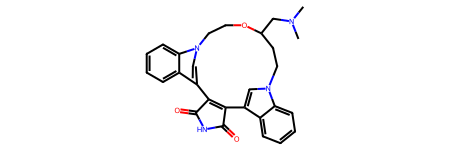

In [30]:
query = Chem.MolFromSmiles("CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C6=CC=CC=C65)C(=O)NC4=O") # SMILES de Ruboxistaurina
query

Luego generamos las huella dactilar de Morgan para la molécula de Ruboxistaurin

In [31]:
circular_fp_query = rdFingerprintGenerator.GetFPs([query])[0]
# Ver la huella digital como un bit
circular_fp_query.ToBitString()

'000000000100000000000000000000000000000000010100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000001000000000000000000000000000000000000000000000000000000100000000001000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000001010001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000001000000000000000000000000000000000000000000000000

## Paso 3: Calcular las fingerprint del conjunto de datos
Ahora generamos las huellas dactilares de Morgan para todas las moléculas en nuestro conjunto de datos.

In [32]:
# Agrega una columna de moléculas al DataFrame a partir de la columna "smiles"
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")

# Genera una lista de huellas digitales circulares (fingerprints) para las moléculas en el DataFrame
circular_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist())

## Paso 4: Calculamos la similitud entre la molécula y el conjunto de datos
Calculamos la similitud de Tanimoto entre la molécula Ruboxistaurin y todas las moléculas de nuestro conjunto de datos utilizando las huellas dactilares de Morgan

In [33]:
# Calcula la similitud de Tanimoto entre la huella digital de la consulta y las huellas digitales de las moléculas en el DataFrame
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)

# Muestra las primeras filas con el identificador ChEMBL de la molécula y su similitud de Tanimoto
molecule_dataset[["molecule_chembl_id", "tanimoto_morgan"]].head()

,molecule_chembl_id,tanimoto_morgan
0,CHEMBL2386094,0.305882
1,CHEMBL3895998,0.138298
2,CHEMBL4084855,0.106383
3,CHEMBL564450,0.362500
4,CHEMBL3957649,0.127660


Ahora podemos organizar los valores para identificar las moléculas más similares a la Ruboxistaurin

In [34]:
# Ordena el DataFrame en función de la similitud de Tanimoto en orden descendente
molecule_dataset.sort_values(by=["tanimoto_morgan"], ascending=False, inplace=True)

# Muestra las cinco primeras moléculas con mayor similitud de Tanimoto
molecule_dataset.head(5)

,molecule_chembl_id,smiles,ROMol,tanimoto_morgan
581,CHEMBL336179,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCn1...,<rdkit.Chem.rdchem.Mol object at 0x17772c7b0>,0.603774
797,CHEMBL130774,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCOC...,<rdkit.Chem.rdchem.Mol object at 0x1777327b0>,0.603774
1271,CHEMBL340259,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCn1cc2...,<rdkit.Chem.rdchem.Mol object at 0x17773fa50>,0.603774
1099,CHEMBL131035,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCn1cc2c2c...,<rdkit.Chem.rdchem.Mol object at 0x17773add0>,0.603774
176,CHEMBL321315,CN1CCCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3cc...,<rdkit.Chem.rdchem.Mol object at 0x1777213c0>,0.593220


Finalmente, podemos ver la molécula Ruboxistaurin y las cinco moléculas más parecidas del conjunto de datos

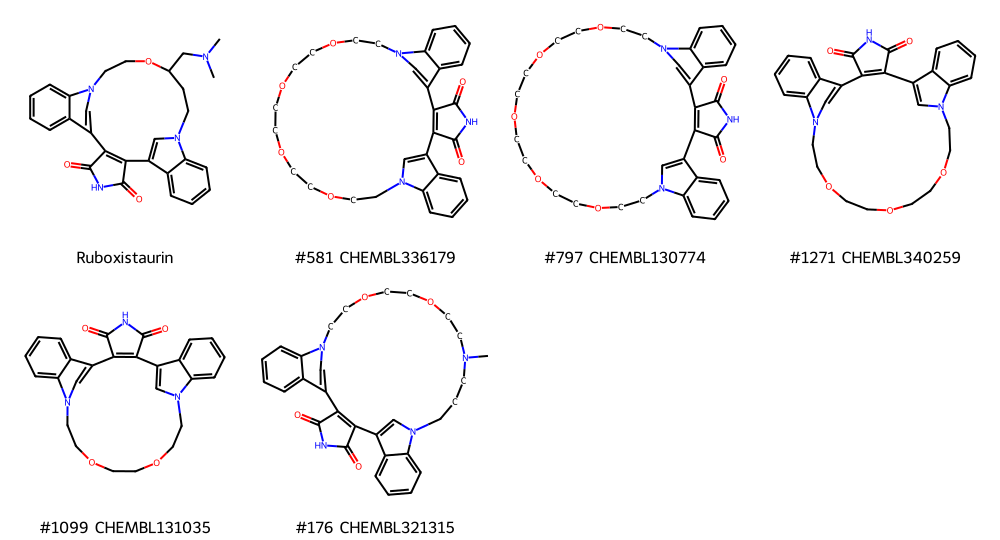

In [35]:
# Número de moléculas principales a visualizar
top_n_molecules = 5

# Selecciona las 'top_n_molecules' con mayor similitud de Tanimoto
top_molecules = molecule_dataset[:top_n_molecules]

# Crea una lista de leyendas con los identificadores ChEMBL de las moléculas seleccionadas
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in top_molecules.iterrows()
]

# Genera una imagen en forma de cuadrícula con la molécula de consulta (Ruboxistaurina) y las moléculas más similares
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),  # Incluye la molécula de consulta y las más similares
    legends=(["Ruboxistaurin"] + legends),  # Asigna las leyendas a cada molécula
    molsPerRow=4,  # Número de moléculas por fila en la cuadrícula
    subImgSize=(250, 270),  # Tamaño de cada imagen de molécula
)

## Distribución de similitud
Para ver gráficamente la distribución de la similitud de Tanimoto, podemos hacer un histograma, recordemos que entre más cerca sea el número a 1, más similares son las moléculas.

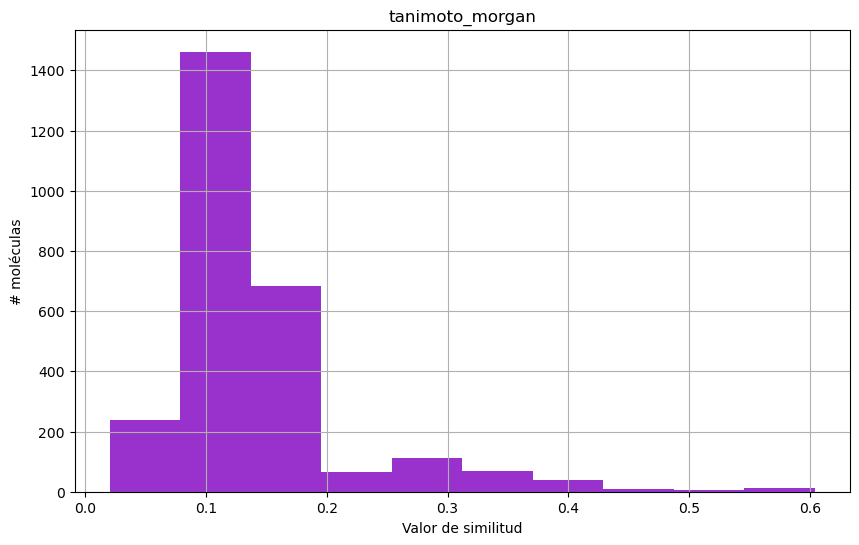

In [36]:
# Configurar la figura de Matplotlib con un tamaño de 10x6
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

# Generar un histograma de los valores de similitud de Tanimoto en la columna "tanimoto_morgan"
# Puedes ver más nombres de colores en el enlace: https://www.w3schools.com/colors/colors_names.asp
molecule_dataset.hist(["tanimoto_morgan"], ax=axes, color="darkorchid")

# Etiqueta del eje X
axes.set_xlabel("Valor de similitud")

# Etiqueta del eje Y
axes.set_ylabel("# moléculas")

# Mostrar la figura
fig;

También podemos hacer un histograma con una curva de estimaciones de densidad kernel usando seaborn. Con este gráfico, podemos ver la manera como se distribuye el conjunto de datos.

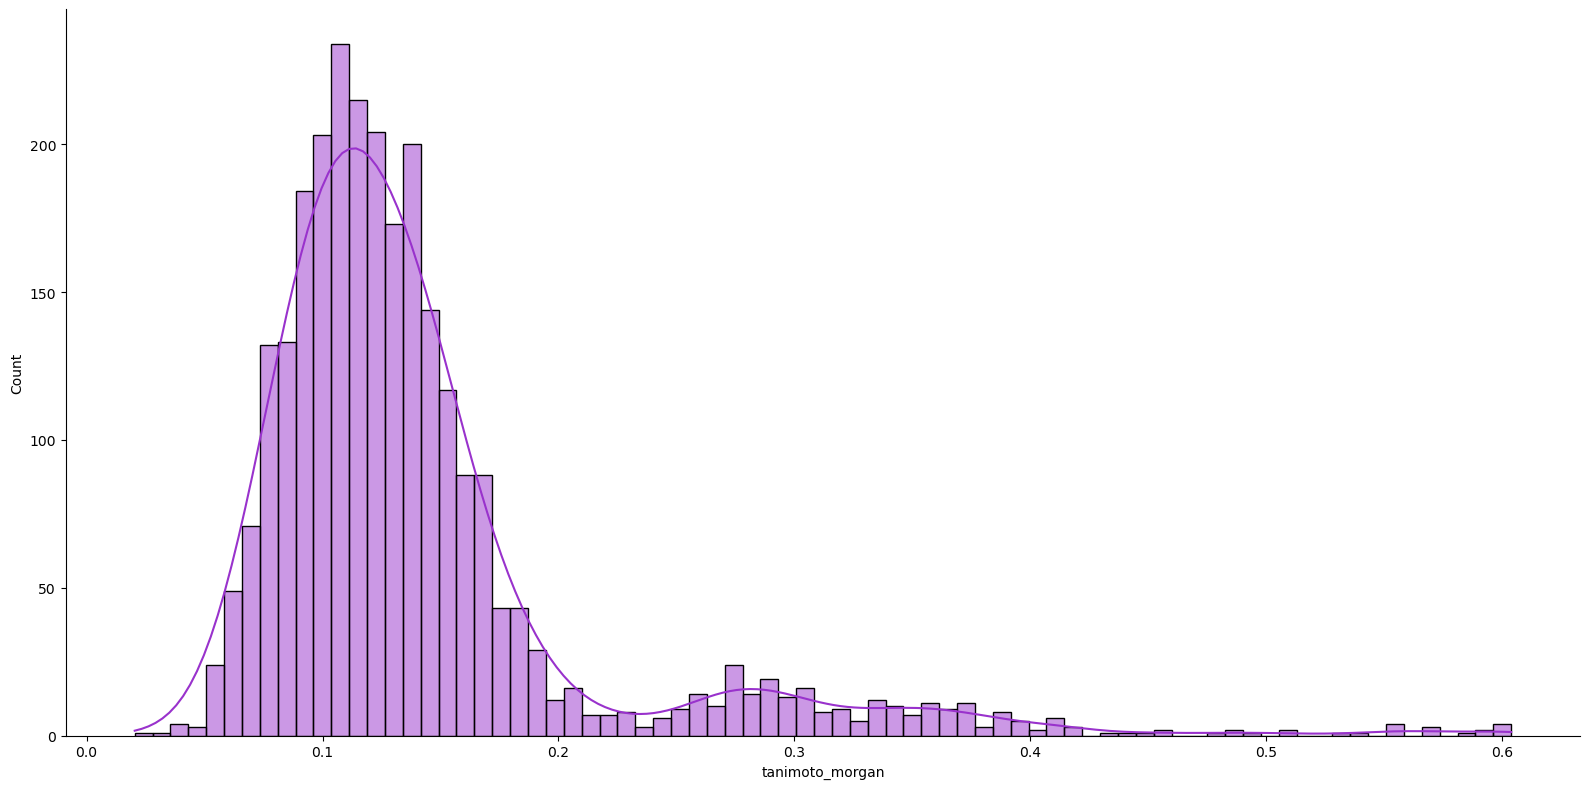

In [37]:
# Generar un gráfico de distribución (displot) con la densidad de kernel (kde) habilitada
# Configurar la altura en 8 y la relación de aspecto en 2 para una visualización más amplia
# Se usa el color "darkorchid" para el gráfico
sns.displot(data=molecule_dataset["tanimoto_morgan"], kde=True, height=8, aspect=2, color="darkorchid")

# Ejemplo 2: Agrupación jerárquica (hierarchical clustering)
El agrupamiento jerárquico (**Hierarchical Clustering** en inglés), es un método comúnmente utilizado para agrupar datos con características similares (los grupos de datos se llaman **clústers**)<sup> **4**</sup>.

El algortimo de agrupamiento jerárquico agrupa los datos basándose en la distancia entre cada uno y buscando que los datos que están dentro de un clúster sean los más similares entre sí. Para nuestro caso, podemos agrupar los compuestos más similares de acuerdo a la distancia de Tanimonoto.

Inicialmente, vamos a utilizar el **agrupamiento tipo Aglomerativo** el cual inicia con cada compuesto como un clúster separado. A cada paso, los dos clústers más cercanos se fusionan creando un nuevo clúster. Estas fusiones se siguen produciendo de manera sucesiva hasta que al final del proceso solo queda un único clúster que aglomera todos los elementos.

Otro aspecto a tener en cuenta es la forma como se mide la **distancia** entre dos clústers, por definición se utiliza la * distancia euclidiana*, pero los algoritmos permiten modificar esta métrica.

## Preparación de datos

Iniciamos cargando el conjunto de datos que contiene los compuestos bioactivos contra la *glucógeno sintasa quinasa-3 beta* lo construimos en el tutorial 2.1_Dataframes.

A partir de los SMILES creamos los objetos *ROMol* y las *fingerprints* de cada compuesto

In [38]:
import pandas as pd
import urllib.parse

# URL original con caracteres especiales
csv_url = 'https://raw.githubusercontent.com/ramirezlab/PILE/main/2. De datos a gráficas: Propiedades drug-likeness y similitud química con python/data/compounds_P49841_full.csv'

# Codificar correctamente la URL
csv_url_encoded = urllib.parse.quote(csv_url, safe=":/")

# Leer el archivo CSV con la URL codificada
molecule_dataset = pd.read_csv(csv_url_encoded, usecols=["molecule_chembl_id", "smiles"], encoding='utf-8')

# Imprimir el número total de compuestos y mostrar las primeras filas
print(f'# total de compuestos: {len(molecule_dataset)}')
molecule_dataset.head()


# total de compuestos: 2697


,molecule_chembl_id,smiles
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL3957649,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1


## Matriz de la similitud de Tanimoto
Similar a lo trabajado en el ejemplo 1, vamos a encontrar la similitud de cada molécula con el resto de moléculas del conjunto.

Vamos a crear una función cuya entrada es el conjunto de *fingerprints* de los compuestos, y cuya salida es la matriz de similitud de Tanimoto, donde se mide la similitud entre dos compuestos.

In [39]:
def tanimoto_matrix(fp_list):
    # Crear una matriz identidad de tamaño N x N, donde N es el número de fingerprints
    N = len(fp_list)
    similarity_matrix = np.identity(N)
    
    # Obtener los índices de las posiciones de la matriz triangular inferior (incluyendo la diagonal)
    a, b = np.tril_indices(N, 0)
    
    # Inicializar una lista para almacenar los valores de similitud
    similarities = list()
    
    # Iterar sobre la lista de fingerprints
    for ind, i in enumerate(fp_list):
        # Comparar el fingerprint actual con todos los anteriores en la lista y almacenar los valores de similitud
        similarities = np.append(similarities, DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind+1]))
        
    # Llenar la matriz de similitud con los valores calculados en la parte inferior
    similarity_matrix[a, b] = similarities
    
    # Hacer la matriz simétrica copiando los valores de la parte inferior a la parte superior
    similarity_matrix[b, a] = similarity_matrix[a, b]
    
    # Retornar la matriz de similitud de Tanimoto
    return similarity_matrix

### Agrupamiento de diez moléculas
Para entender el proceso de agrupamiento vamos a trabajar solamente con las primeras diez moléculas del conjunto. Comenzamos creando una lista con los fingerprints de las diez moléculas.

In [55]:
# Seleccionar los primeros 10 fingerprints de la lista de huellas digitales de Morgan
list_fingerprints = circular_fp_list[0:10]

Ahora, encontramos la matriz de similitud de tanimoto con los diez fingerprints

In [41]:
# Calcular la matriz de similitud de Tanimoto solo para los primeros 10 compuestos
similarity_matrix = tanimoto_matrix(list_fingerprints)

# Mostrar la matriz de similitud
similarity_matrix

array([[1.        , 0.14285714, 0.09345794, 0.28421053, 0.15533981,
        0.09174312, 0.55555556, 0.12621359, 0.09009009, 0.11538462],
       [0.14285714, 1.        , 0.17708333, 0.10280374, 0.796875  ,
        0.18556701, 0.18446602, 0.25842697, 0.67142857, 0.77777778],
       [0.09345794, 0.17708333, 1.        , 0.17346939, 0.16666667,
        0.83606557, 0.11214953, 0.67692308, 0.26666667, 0.17204301],
       [0.28421053, 0.10280374, 0.17346939, 1.        , 0.11428571,
        0.18181818, 0.25252525, 0.14      , 0.13333333, 0.10679612],
       [0.15533981, 0.796875  , 0.16666667, 0.11428571, 1.        ,
        0.17525773, 0.1980198 , 0.24719101, 0.52631579, 0.60869565],
       [0.09174312, 0.18556701, 0.83606557, 0.18181818, 0.17525773,
        1.        , 0.13084112, 0.68181818, 0.23404255, 0.18085106],
       [0.55555556, 0.18446602, 0.11214953, 0.25252525, 0.1980198 ,
        0.13084112, 1.        , 0.13461538, 0.14953271, 0.18      ],
       [0.12621359, 0.25842697, 0.6769230

Podemos representarla por medio de un mapa de calor:

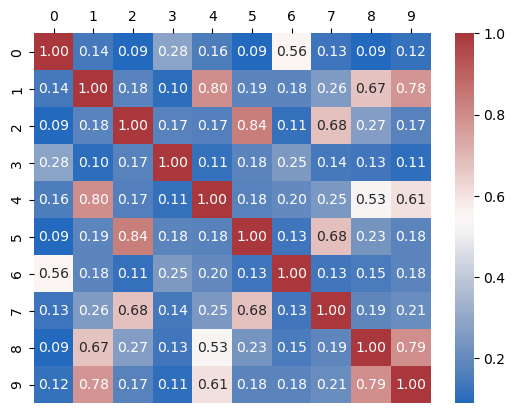

In [42]:
# Calcular la matriz de similitud de Tanimoto solo para los primeros 10 compuestos
similarity_matrix = tanimoto_matrix(list_fingerprints)

# Crear un mapa de calor (heatmap) con la matriz de similitud
# 'annot=True' muestra los coeficientes de Tanimoto en cada celda
# 'fmt=".2f"' limita la visualización de los valores a dos decimales
# 'cmap="vlag"' usa una escala de colores para representar los valores de similitud
ax = sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap="vlag")

# Quitar etiquetas de los ejes
ax.set(xlabel="", ylabel="")

# Colocar los ticks del eje X en la parte superior
ax.xaxis.tick_top()

#### Agrupamiento por distancias
Como lo explicamos inicialmente, el **agrupamiento por aglomeración** consiste en fusionar consecutivamente aquellos clústers que estén más cercados, para entender el agrupamiento podemos utilizar el método [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), el cual crea una *matriz de enlace* (linkage matrix) con el orden con el cual se agruparon los diferentes clústers (por defecto, la metrica de medida es la *distancia euclideana* y el método de agrupamiento es el *punto más cercano*), nosotros vamos a trabajar con la distancia media de los elementos del agrupamiento (*average*).

In [43]:
# Realizar el clustering jerárquico utilizando el método de enlace promedio (average linkage)
# 'similarity_matrix' es la matriz de similitud de Tanimoto calculada previamente
Z = linkage(similarity_matrix, method='average')

# Mostrar la estructura del clustering jerárquico resultante
Z

array([[ 2.        ,  5.        ,  0.23554759,  2.        ],
       [ 8.        ,  9.        ,  0.34334866,  2.        ],
       [ 1.        ,  4.        ,  0.36466205,  2.        ],
       [ 7.        , 10.        ,  0.50012338,  3.        ],
       [11.        , 12.        ,  0.57159297,  4.        ],
       [ 0.        ,  6.        ,  0.63974664,  2.        ],
       [ 3.        , 15.        ,  1.08456092,  3.        ],
       [13.        , 16.        ,  1.55505923,  6.        ],
       [14.        , 17.        ,  1.6118122 , 10.        ]])

En la *i-ésima* fila, `Z[i,0]` y `Z[i,1]` indican los clusters que son combinaron para formar el clúster $n+i$. `Z[i,2]` indica la distancia entre los clústers y `Z[i,3]` representa el número de compuestos del nuevo clúster.
Recordemos que iniciamos con diez clústers enumerados del 0 al 9 (las diez moléculas iniciales), así, las filas de la matriz de enlace Z son:
- **fila-0**: Se crea el clúster 10, conformado por la molécula 1 (clúster 1) y la mólecula 5 (clúster 5), la distancia entre el clúster 1 y 5 es de 0.235548, y el nuevo clúster tiene 2 moléculas
- **fila-1**: Se crea el clúster 11, conformado por la molécula 8 (clúster 8) y la mólecula 9 (clúster 9), la distancia entre el clúster 8 y 9 es de 0.343349, y el nuevo clúster tiene 2 moléculas
- **fila-2**: Se crea el clúster 12, conformado por la molécula 2 (clúster 2) y la mólecula 7 (clúster 7), la distancia entre el clúster 2 y 7 es de 0.364662, y el nuevo clúster tiene 2 moléculas
- **fila-3**: Se crea el clúster 13, conformado por la molécula 4 (clúster 4) y el clúster 10 (creado en la **fila-0**), la distancia entre el clúster 4 y 10 es de 0.500123, y el nuevo clúster tiene 3 moléculas
- **fila-4**: Se crea el clúster 14, conformado por el clúster 11 (creado en la **fila-1**) y el clúster 12 (creado en la **fila-2**), la distancia entre el clúster 11 y 12 es de 0.571593, y el nuevo clúster tiene 4 moléculas
- **fila-5**: Se crea el clúster 15, conformado por la molécula 0 (clúster 0) y la mólecula 6 (clúster 6), la distancia entre el clúster 0 y 6 es de 0.639747, y el nuevo clúster tiene 2 moléculas
- **fila-6**: Se crea el clúster 16, conformado por la molécula 3 (clúster 3) y el clúster 15 (creado en la **fila-5**), la distancia entre el clúster 3 y 15 es de 1.084561, y el nuevo clúster tiene 3 moléculas
- **fila-7**: Se crea el clúster 17, conformado por el clúster 13 (creado en la **fila-3**) y el clúster 16 (creado en la **fila-6**), la distancia entre el clúster 13 y 16 es de 1.555059, y el nuevo clúster tiene 6 moléculas
- **fila-8**: Se crea el clúster 18, conformado por el clúster 14 (creado en la **fila-4**) y el clúster 17 (creado en la **fila-17**), la distancia entre el clúster 14 y 17 es de 1.611812, y el nuevo clúster tiene 10 moléculas

#### Representación: el *dendograma*
La manera de representar un agrupamiento jerárquico es con un dendrograma

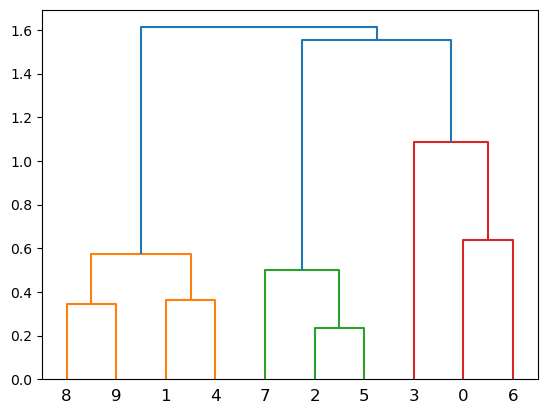

In [45]:
# Generar el dendrograma a partir de la matriz de clustering 'Z'
dn = dendrogram(Z)

Las líneas verticales del dendrograma ilustran las fusiones (o divisiones) realizadas en cada etapa del agrupamiento. Podemos ver la distancia, los distintos niveles de asociaciones entre los datos individuales y también las asociaciones entre clústers. Recordemos que la distancia utilizada fue la euclidiana, la cual podemos modificar cuando armamos Z.

#### Clustermap
Todo lo anterior se puede organizar en una matriz y graficar por medio de un mapa de calor de agrupamiento jerárquico, note que el orden de los compuestos no necesariamente es el mismo orden que el del dendograma

/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/jessicavalero/anaconda3/envs/chemo/lib/python3.8/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


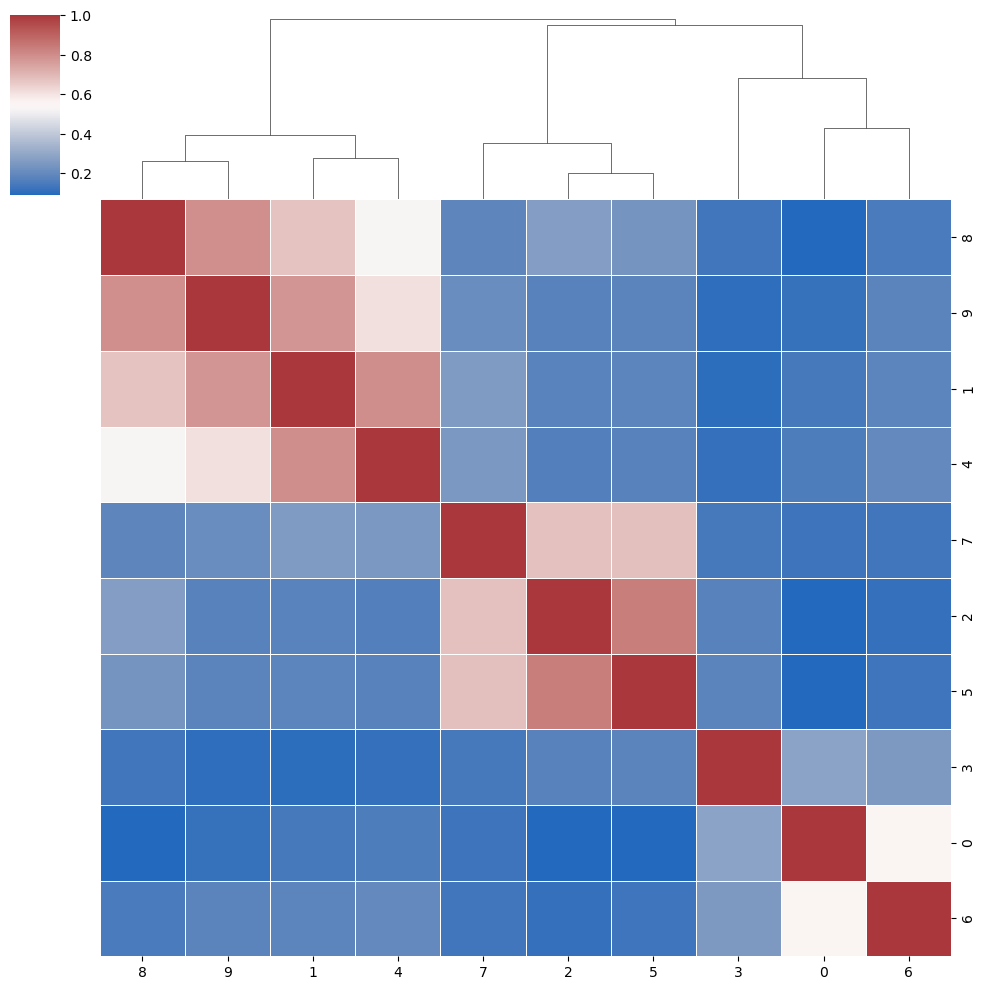

In [46]:
# Crear un clustermap (mapa de calor con clustering jerárquico) basado en la matriz de similitud de Tanimoto
g = sns.clustermap(similarity_matrix, method='average',
                   cmap="vlag",  # Mapa de colores
                   dendrogram_ratio=(.1, .2),  # Proporción del dendrograma en los ejes (filas, columnas)
                   linewidths=.5)  # Grosor de las líneas de separación en el mapa de calor

# Eliminar el dendrograma de las filas para una visualización más clara
g.ax_row_dendrogram.remove()

#### Umbral de agrupamiento
Podemos utilizar la distancia entre los clústers como **límite** para agrupar los compuestos, por ejemplo, si elegimos agrupar con una distancia es menor o igual que 0.6, se formarían 5 grupos con los siguientes compuestos:
- Clúster-1: (1, 4, 8, 9)
- Clúster-2: (7, 2, 5)
- Clúster-3: 3
- Clúster-4: 0
- Clúster-5: 6

El método ['fcluster'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) organiza un arreglo de $n$ elementos, donde cada elemento indica número del clúster al que pertenece el compuesto de esa posición

In [47]:
# Realizar el clustering jerárquico sobre la matriz de similitud de Tanimoto
Z = linkage(similarity_matrix)

# Obtener los clusters a partir de la matriz de enlace Z
# 't=0.6' define el umbral de distancia para la formación de clusters
# 'criterion="distance"' indica que se usará la distancia de enlace para definir los clusters
clusters = fcluster(Z, t=0.6, criterion='distance')

# Mostrar los clusters asignados a cada molécula
clusters

array([3, 1, 2, 5, 1, 2, 4, 2, 1, 1], dtype=int32)

### Algoritmo de agrupamiento *Butina*: Centroides y esferas de exclusión
Un algoritmo utilizado comunmente para agrupar moléculas es el conocido como el *algortimo de agrupamiento Butina* (Butina clustering algorithm)<sup> **5** </sup>

Podemos utilizar la librería `rdkit` para implementar este algorítmo (`Butina.ClusterData`). Como entrada se necesita una lista con las distancias de Tanimoto de los compuestos. Esta lista la podemos encontrar a partir de la matriz de similitud de Tanimoto donde las distancias se pueden hallar con la fórmula $distancia = 1 - similitud$.

Para armar la lista podemos utilizar la función de la matriz de tanimoto, separar solamente los elementos que están debajo de la diagonal principal y hallar la distancia

In [48]:
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # distancias de los compuestos

Ahora escogemos un umbral de distancia para realizar el agrupamiento, por ejemplo, si escogemos como umbral 0.4, se obtienen cinco clústers.

In [49]:
# Aplicar el algoritmo de clustering de Butina basado en la matriz de similitud
# 'dist_similarity_matrix' es la matriz de similitud de Tanimoto transformada en una matriz de distancia
# 'len(list_fingerprints)' es el número total de fingerprints a considerar
# 'distThresh=0.4' establece un umbral de distancia para definir los clusters
# 'isDistData=True' indica que los datos de entrada son una matriz de distancias
clusters = Butina.ClusterData(dist_similarity_matrix, len(list_fingerprints), distThresh=0.4, isDistData=True)

# Ordenar los clusters por tamaño en orden descendente (los más grandes primero)
clusters = sorted(clusters, key=len, reverse=True)

# Mostrar los clusters obtenidos
clusters


[(9, 1, 4, 8), (7, 2, 5), (6,), (3,), (0,)]

**Observación**: Aunque el agrupamiento es similar al encontrado con el método `fcluster` note que el umbral utilizado es diferente, adicionalmente, el algoritmo de `Butina` determina el *centroide* del clúster, el cual será similar a cualquier otra molécula del clúster de acuerdo al valor del umbral dado. El primer elemento de cada clúster es el centroide.

## Método del codo (Elbow Method)
Uno de los problemas que nos encontramos a la hora de aplicar el agrupamiento es la elección del número de Clusters. No existe un criterio objetivo ni ampliamente válido para la elección de un número óptimo de Clusters; pero tenemos que tener en cuenta, que una mala elección de los mismos puede dar lugar a realizar agrupaciones de datos muy heterogéneos (pocos Clusters); o datos, que siendo muy similares unos a otros los agrupemos en Clusters diferentes (muchos Clusters).

El método del codo utiliza los valores de la inercia obtenidos tras aplicar el agrupamiento para diferentes números de clusters (desde 1 a N Clusters), siendo la **inercia** la *suma de las distancias al cuadrado de cada objeto del Cluster a su centroide*. Luego, podemos hallar el *promedio* de las inercias para cada N (comúnmente llamado *distorsión*) y representamos en una gráfica la distorsión respecto al número de clústers<sup> **6** </sup>. La gráfica nos dirve para apreciar el cambio y a partir de esta podemos estimar el número óptimo de clústers a seleccionar.

Comenzamos definiendo una función que determine la inercia y distorsión, ya que vamos a utilizar el método de Butina para hacer el clústering, debemos tener en cuenta que este depende del *umbral de similitud* y a partir de este umbral se halla el número de clústers (entre más pequeño sea el umbral, más clústers, pues es menor la cantidad de moléculas similares).

In [50]:
def distorion_tanimoto(clusters, full_dataset):
    # Lista para almacenar la inercia de cada clúster
    inertia = list()
    
    # Iterar sobre cada clúster en la lista de clusters
    for cluster in clusters:
        # Extraer los compuestos que pertenecen al clúster actual
        cluster_dataset = full_dataset.iloc[list(cluster)]
        
        # Seleccionar el primer fingerprint del clúster como centroide
        circular_fp_query = cluster_dataset['morgan_fp'].iloc[0]
        
        # Crear una lista con los fingerprints de todos los elementos en el clúster
        circular_fp_list = list(cluster_dataset['morgan_fp'])
        
        # Calcular el cuadrado de la distancia intra-cluster usando la similitud de Tanimoto
        sqrt_dist_to_centroid = (1 - np.array(DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)))**2
        
        # Sumar las distancias cuadráticas de cada elemento al centro del clúster
        inertia.append(sum(sqrt_dist_to_centroid))
    
    # Calcular la distorsión como la media de las inercias de cada clúster
    distortion = np.mean(inertia)
    
    # Retornar el número de clusters y el valor de distorsión calculado
    return len(clusters), distortion


Ahora repetimos el proceso anterior, variando el umbral de similitud de 0 a 1 con pasos de 0.05 (*observe la linea 7: `np.arange(0,1,0.05)`*), luego creamos una tabla de resultados para poder graficarlos

In [58]:
from rdkit.Chem import AllChem

# Generar los Morgan fingerprints para cada molécula en la columna "ROMol"
morgan_fp_list = [
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    for mol in molecule_dataset["ROMol"]
]

# Lista para almacenar los resultados de clustering con diferentes umbrales
result = list()

# Seleccionar un subconjunto de datos con las primeras 10 moléculas
molecule_mini_dataset = molecule_dataset[:10]

# Extraer los fingerprints de Morgan del subconjunto de datos
list_fingerprints = molecule_mini_dataset['morgan_fp']

# Calcular la matriz de similitud de Tanimoto para los fingerprints seleccionados
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud

# Obtener los índices de los elementos debajo de la diagonal principal de la matriz
a, b = np.tril_indices(len(list_fingerprints), -1)

# Convertir la matriz de similitud en una matriz de distancias (1 - similitud)
dist_similarity_matrix = 1 - similarity_matrix[a, b]  # Distancias de los compuestos

# Iterar sobre un rango de valores de umbral de corte (cutoff) desde 0 hasta 1 con incrementos de 0.05
for i in np.arange(0, 1, 0.05):
    cutoff = round(i, 2)  # Redondear el umbral de corte a 2 decimales
    
    # Aplicar el clustering de Butina con el umbral de corte actual
    clusters = Butina.ClusterData(dist_similarity_matrix, len(list_fingerprints), distThresh=cutoff, isDistData=True)
    
    # Calcular el número de clusters y la distorsión intra-cluster
    n, dist = distorion_tanimoto(clusters, molecule_mini_dataset)
    
    # Almacenar los resultados en la lista
    result.append((cutoff, n, dist))

# Convertir la lista de resultados en un DataFrame para facilitar el análisis
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])

# Mostrar la tabla con los resultados
table


KeyError: 'ROMol'

In [ ]:
table.plot(x='N_clusters', y='distortion')

La gráfica muestra que cuando el número de clústers es `N=4` hay un cambio brusco (como si fuera el codo de un brazo), por tanto, podemos escoger este como el número óptimo de clústers. Al revisar la tabla vemos que el umbral que debemos escoger es `cutoff=0.45`.

## Agrupamiento jeráquico del total de datos
Podemos utilizar lo aprendido con el agrupamiento de diez compuestos para representar el agrupamiento de todo el conjunto de compuestos.

Iniciemos encontrando la matriz de similitud de Tanimoto, ya que son 2605 compuestos, la matriz de similitud tiene un tamaño de 2605 x 2605

**Observación**: la variable *circular_fp_list* tiene la lista de todas las fingerprints de los compuestos

In [ ]:
similarity_matrix_full = tanimoto_matrix(circular_fp_list)
similarity_matrix_full.shape

Observemos el mapa de calor de la matriz de similitud, la cual aún no está organizada

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(similarity_matrix_full, cmap="vlag",
                 yticklabels=False,xticklabels=False)

### Agrupación: Algoritmo de agrupamiento Butina
Similar a la agrupación realizada con los diez compuestos, vamos a crear una función en donde podemos decidir el umbral de la distancia de Tanimoto, por ejemplo, supongamos que queremos agrupar moléculas cuya similitud es menor o igual a *cutoff*=0.2.
**Observación**: Recordemos que estamos utilizando el algoritmo de agrupamiento *Butina*

In [ ]:
def cluster_fingerprints(fp_list, cutoff=0.2):
    # Calcular la matriz similitud de Tanimoto
    similarity_matrix = tanimoto_matrix(fp_list)  # Matriz de similitud
    # Encontrar la distancias entre los compuestos, guardar los datos como una lista
    a, b = np.tril_indices(len(fp_list), -1)
    dist_similarity_matrix = 1 - similarity_matrix[a, b]
    # Ahora agrupar los datos con el algoritmo Butina:
    clusters = Butina.ClusterData(dist_similarity_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Al ejecutar la función *cluster_fingerprints* se crean los agrupamientos, iniciando por aquellos que mayor cantidad de moléculas tiene, veamos los 10 primeros.

In [ ]:
# Ejecutar el procedimiento de agrupación para el conjunto de datos, distancia: 0.2
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.2)
# Clústers más grandes
print(clusters[:10])

Como estamos trabajando con un conjunto grande de datos, no es buena idea imprimir toda la lista de los clústers, sin embargo, podemos resumir la información en una tabla de frecuencias.

In [ ]:
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order
frec_table

Podemos ver que el clúster más grande (el primero) tiene 14 elementos y que hay 1494 compuestos que no se agruparon (clústers individuales)
Veamos gráficamente la cantidad de elementos en los clústers de mayor tamaño y cuántos hay de cada uno

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))  # Configurar la figura de matplotlib
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1])
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

Podemos examinar con más detalle el primer clúster de 14 elementos:

In [ ]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

In [ ]:
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)

También podemos tener un breve informe sobre el número de grupos y sus tamaños, dependiendo del tamaño del cúlster:

In [ ]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g10 = sum(1 for c in clusters if len(c) > 10)

print("Número total de clústeres: ", len(clusters))
print("# clusters con solo 1 compuesto: ", num_clust_g1)
print("# clusters con >5 compuestos: ", num_clust_g5)
print("# clusters con >10 compuestos: ", num_clust_g10)

#### Número óptimo de clústers y umbral de similitid

Utilizando el algoritmo que usamos para los diez elementos, podemos hallar la *distorsión* para diferentes números de clúster (`N`).


In [ ]:
result = list()
# Ahora utilizamos el total de moléculas
list_fingerprints = molecule_dataset['morgan_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos
for i in np.arange(0,1,0.05):
    cutoff = round(i,2)
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

In [ ]:
table.plot(x='N_clusters', y='distortion')

Como vemos, después de `N=200` (número de clústers) no hay gran variación de la distorsión, por tanto, no necesitamos variar de 0 a 1 el umbral de similitud (`cutoff`).  Vamos a cambiar la línea 7 para que solo llegue a 0.5 en lugar de 1.

In [ ]:
result = list()
# Ahora utilizamos el total de moléculas
list_fingerprints = molecule_dataset['morgan_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos
for i in np.arange(0,0.5,0.05):
    cutoff = round(i,2)
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

In [ ]:
table.plot(x='N_clusters', y='distortion')

En la gráfica pordemos apreciar que al rededor de `N = 1500` hay un cambio brusco en la distorsión. La Tabla nos permite ver que para `N=1502` el `cutoff=0.25`. Veamos como queda el clústering con este valor:

In [ ]:
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.25)
fig, ax = plt.subplots(figsize=(10, 3)) # Configurar la figura de matplotlib
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order

ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")
ax.set_title(f"Límite: 0.25")
ax.set_xlabel("# total de clústers")
ax.set_ylabel("# total de elementos")
plt.show()
plt.close()

El clúster con más moléculas similares tiene 18 moléculas

In [ ]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

In [ ]:
print(f'{len(molecules_cluster0)} moleculas del clúster de mayor tamaño')
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
    mols= molecules_cluster0["ROMol"].tolist(),
    legends=legends,
    molsPerRow=5,
    subImgSize=(250, 270),
)

## Clustermap
También podemos organizar la matriz de similitud de Tanimoto en un mapa de calor del agrupamiento jerárquico donde podemos ver cómo se agrupan las moléculas que mayor simlitud presentan

In [ ]:
from matplotlib.pyplot import figure
similarity_matrix_full = tanimoto_matrix(circular_fp_list)

g = sns.clustermap(similarity_matrix_full, cmap="vlag",
                   dendrogram_ratio=(.1,.2),
                   yticklabels=False,xticklabels=False,
                   figsize=(10,10))
g.ax_row_dendrogram.remove()
!mkdir -p data/
plt.savefig('./data/TanimotoSimilarity.png', bbox_inches='tight', dpi=500)
plt.show()
plt.close()

# Actividad práctica

Teniendo en cuenta lo revisado en esta segunda parte, realice un código en python con el cual pueda:

1. Seleccionar el clúster número 20 realizado con el algoritmo de agrupamiento Butina y un cutoff de 0.25 en esta práctica.
2. Calcular la matriz de similitud de Tanimoto, encontrar las distancias entre los compuestos que integran este clúster y hallar la distorsión para diferentes números de clústers utilizando el algoritmo de agrupamiento Butina.
3. Selecionar el umbral de similitud más adecuado según el método del codo.


Al finalizar deberá preparar un documento en formato PDF en el cual adjunte el input y como resultado de ejecución:
1. Tabla con cutoff, N_clusters y distortion.
2. Gráfico de lineas N_clusters vs Distortion.
3. Gráfico de barras para el # total de clústers y # total de elementos según el cutoff seleccionado.


# Conclusión

En esta práctica, hemos aprendido cómo usar huellas dactilares y medidas de similitud para comparar una molécula de consulta con un conjunto de datos de moléculas y clasificar la molécula por similitud. Además, aprendimos sobre la agrupación en clústeres de un conjunto de datos compuesto y discutimos cómo elegir un umbral de agrupación razonable.

# Referencias

1.  Seo, M., Shin, H. K., Myung, Y., Hwang, S., & No, K. T. (2020). Development of natural compound molecular fingerprint (Nc-mfp) with the dictionary of natural products (Dnp) for natural product-based drug development. Journal of Cheminformatics, 12(1), 6. https://doi.org/10.1186/s13321-020-0410-3
2. Capecchi, A., Probst, D., & Reymond, J.-L. (2020). One molecular fingerprint to rule them all: Drugs, biomolecules, and the metabolome. Journal of Cheminformatics, 12(1), 43. https://doi.org/10.1186/s13321-020-00445-4
3. Rácz, A., Bajusz, D., & Héberger, K. (2018). Life beyond the Tanimoto coefficient: Similarity measures for interaction fingerprints. Journal of Cheminformatics, 10(1), 48. https://doi.org/10.1186/s13321-018-0302-y
4. Nielsen, F. (2016). Hierarchical clustering. En F. Nielsen (Ed.), Introduction to HPC with MPI for Data Science (pp. 195-211). Springer International Publishing. https://doi.org/10.1007/978-3-319-21903-5_8
5. Butina, D. (1999). Unsupervised data base clustering based on daylight’s fingerprint and tanimoto similarity: A fast and automated way to cluster small and large data sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381
6. Shi, C., Wei, B., Wei, S., Wang, W., Liu, H., & Liu, J. (2021). A quantitative discriminant method of elbow point for the optimal number of clusters in clustering algorithm. EURASIP Journal on Wireless Communications and Networking, 2021(1), 31. https://doi.org/10.1186/s13638-021-01910-w